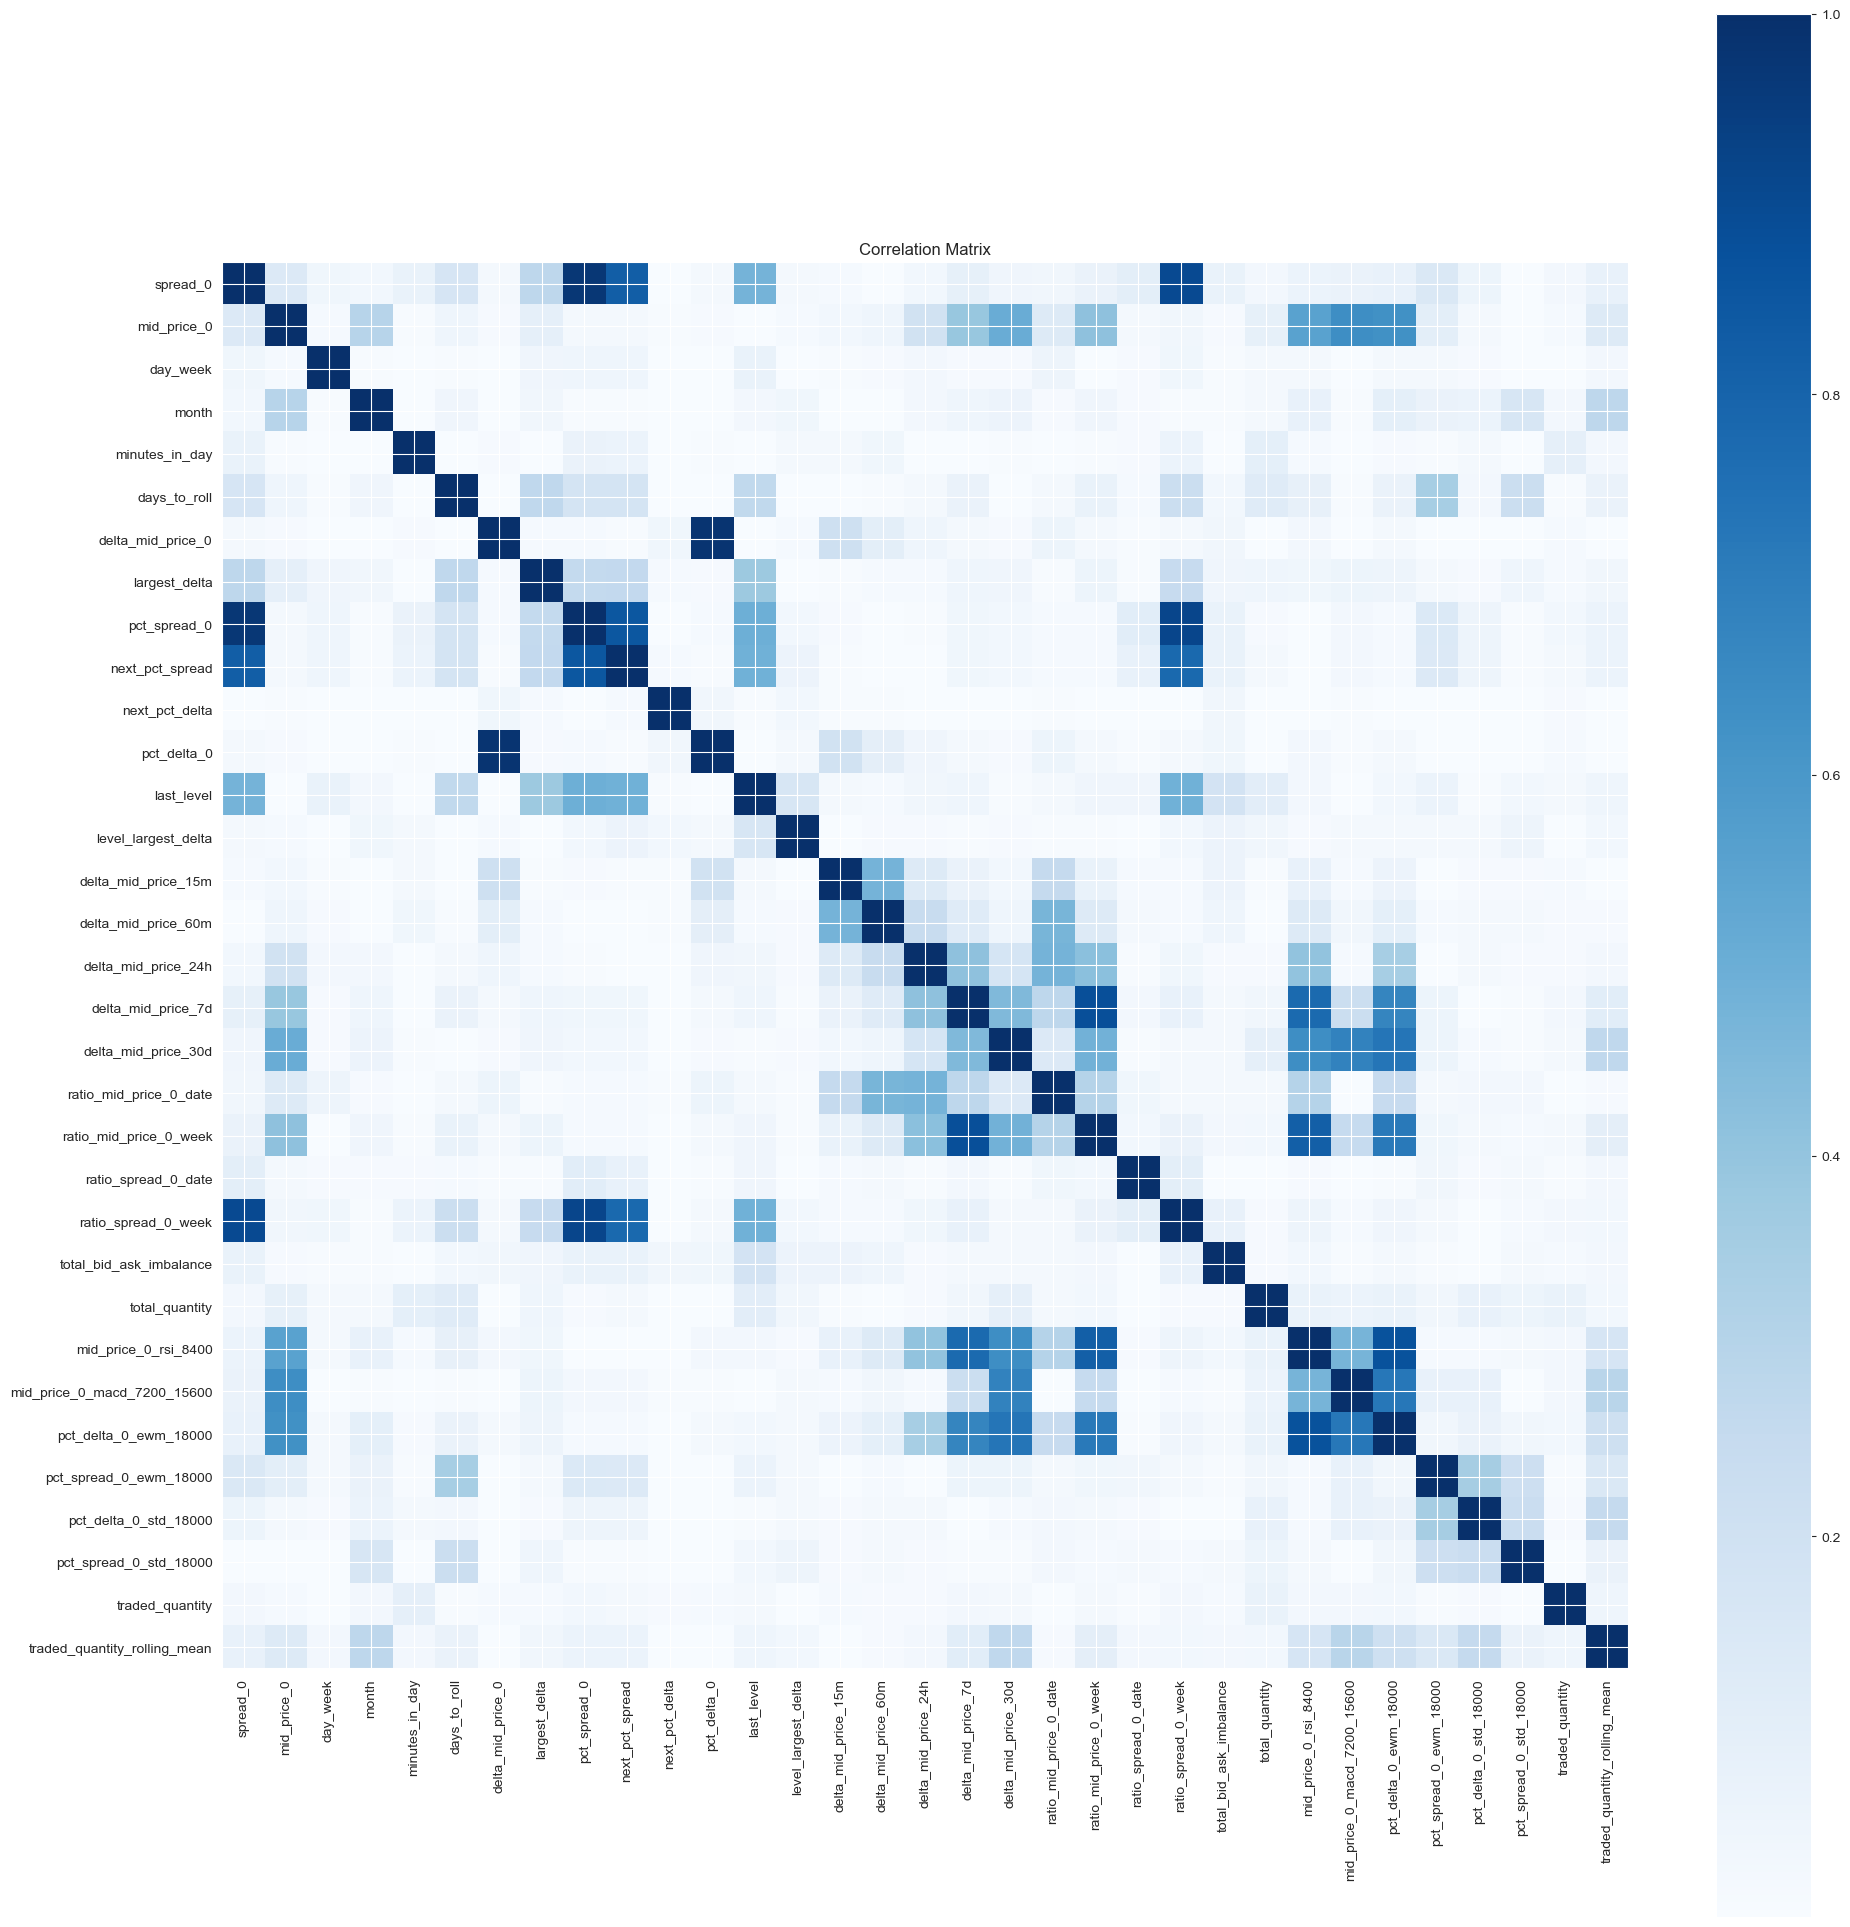

In [18]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

parquet_path = "C:/Users/Riccardo/Documents/TTF_all/TTF_M1/train.parquet"
df = pl.read_parquet(parquet_path).drop('year')
df2 = df.select([col for col in df.columns if col not in ['timestamp', 'prod']])
corr_matrix = df2.corr()
corr_matrix = corr_matrix.select(pl.col(corr_matrix.columns).abs())

plt.figure(figsize=(20, 20))
plt.imshow(corr_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()

num_cols = corr_matrix.columns
ticks = np.arange(len(num_cols))
plt.xticks(ticks, num_cols, rotation=90)
plt.yticks(ticks, num_cols)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

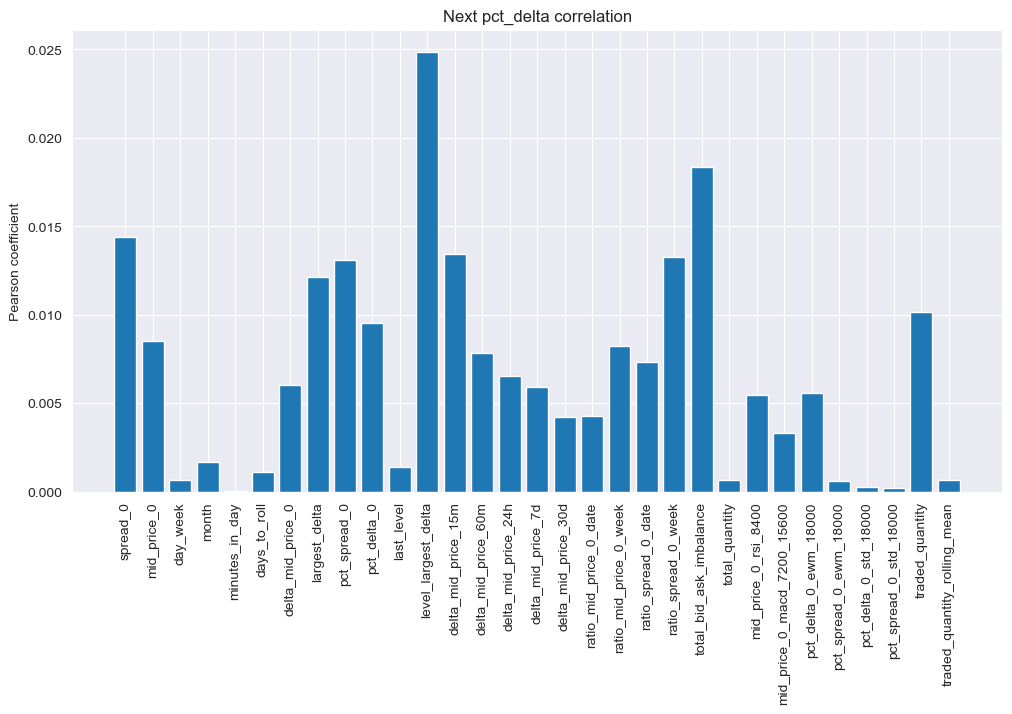

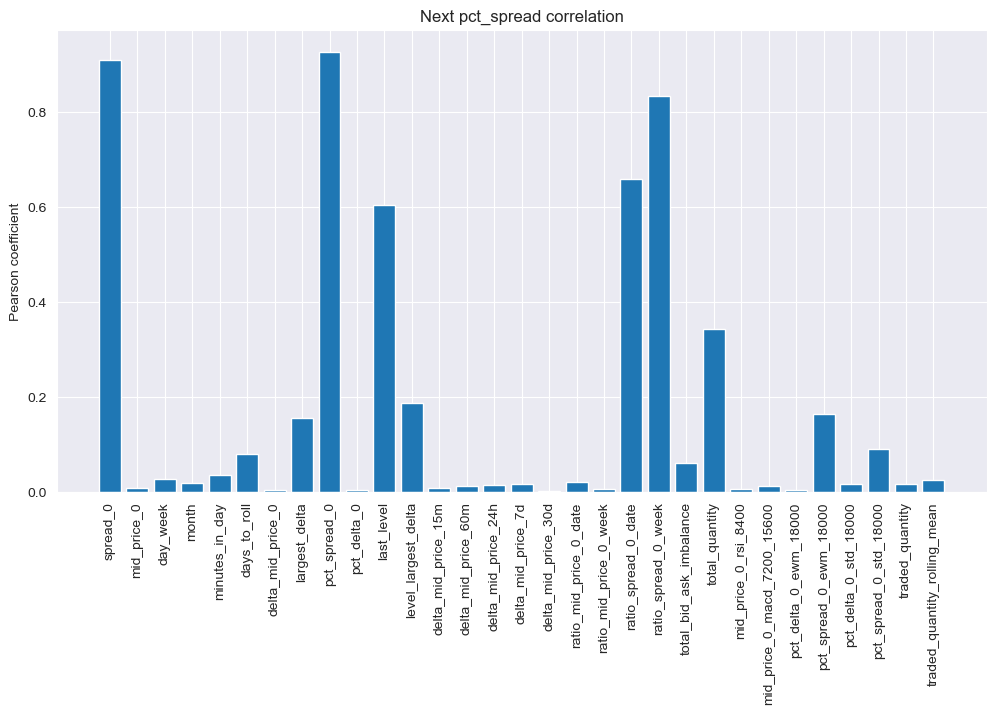

In [10]:
next_pct_delta_corr = corr_matrix.select(pl.col('next_pct_delta'))['next_pct_delta'].to_list()
next_pct_spread_corr = corr_matrix.select(pl.col('next_pct_spread'))['next_pct_spread'].to_list()

to_remove = [df2.columns.index('next_pct_delta'), df2.columns.index('next_pct_spread')]
to_remove.sort(reverse=True)

for index in to_remove:
    next_pct_delta_corr.pop(index)
    next_pct_spread_corr.pop(index)
    
y_columns = ['next_pct_delta', 'next_pct_spread']
x_columns = [col for col in df2.columns if col not in y_columns]

plt.figure(figsize=(12, 6))
plt.bar(x_columns, next_pct_delta_corr)
plt.title('Next pct_delta correlation')
plt.ylabel('Pearson coefficient')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(x_columns, next_pct_spread_corr)
plt.title('Next pct_spread correlation')
plt.ylabel('Pearson coefficient')
plt.xticks(rotation=90)
plt.show()


Evaluating delta_class
Accuracy: 0.330

Confusion matrix:
 [[17890  1149 14314]
 [23352  5526 23090]
 [16468  1172 15698]]


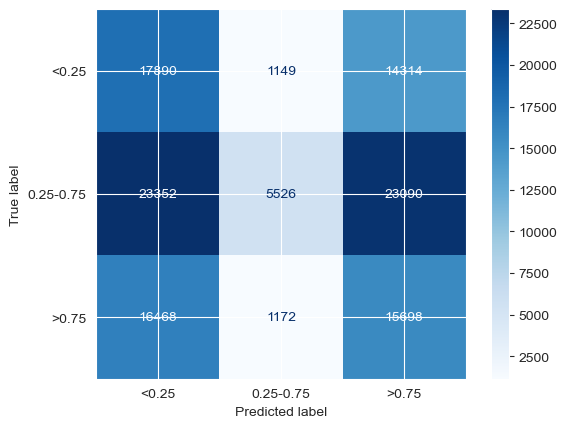

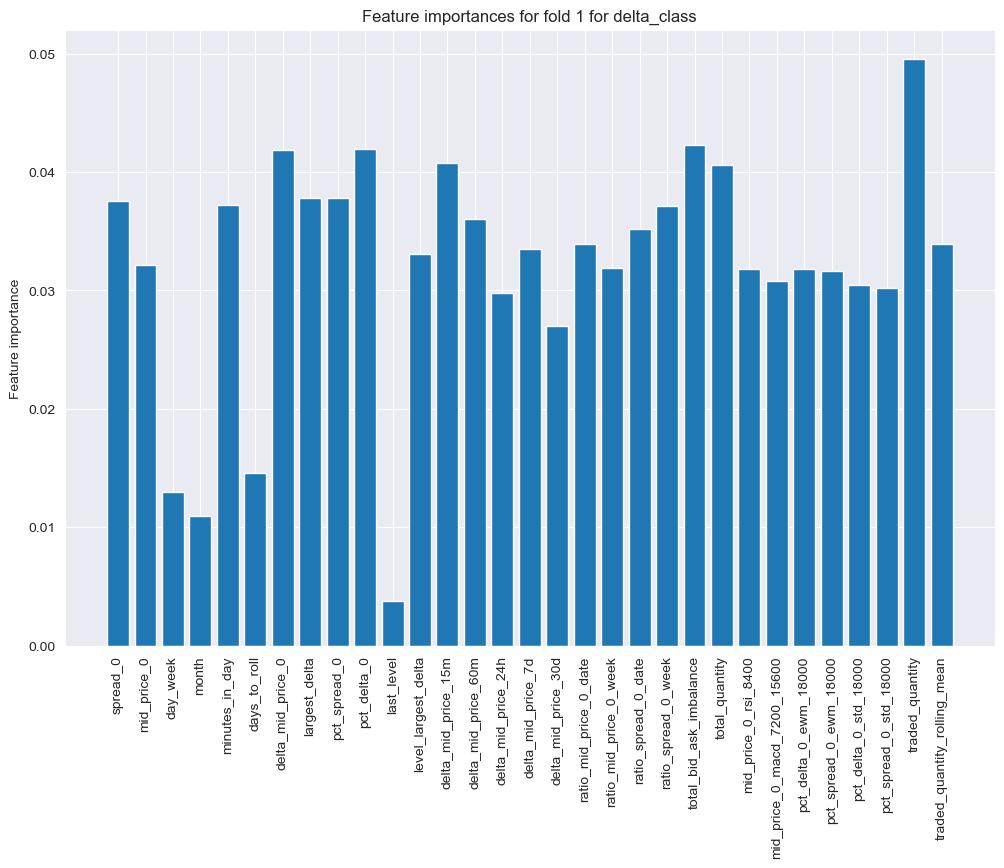

---------------------------------------------------
Accuracy: 0.353

Confusion matrix:
 [[18328  1044 17462]
 [19761  2997 21135]
 [16328  1041 20562]]


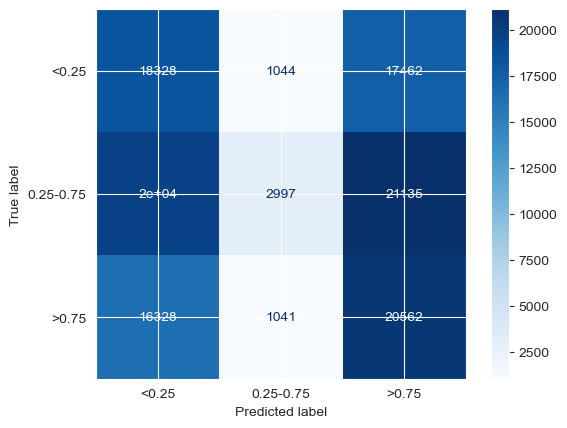

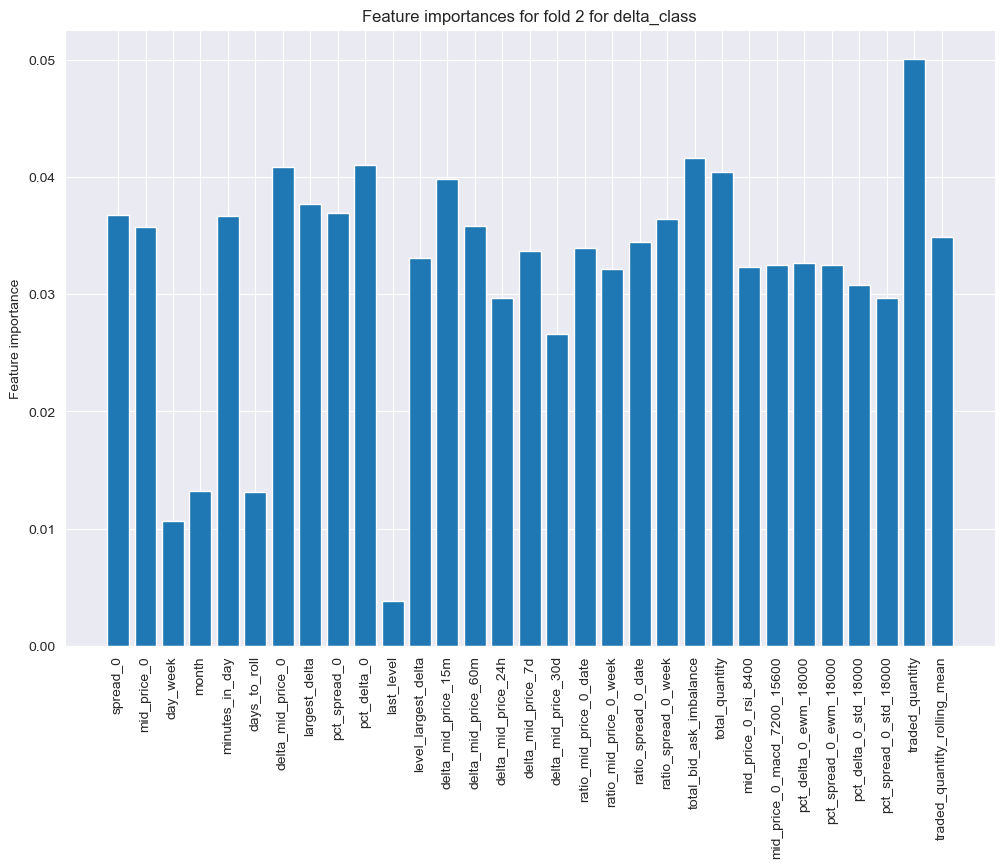

---------------------------------------------------
Accuracy: 0.349

Confusion matrix:
 [[19014  1306 16851]
 [19888  3090 19576]
 [18319  1363 19251]]


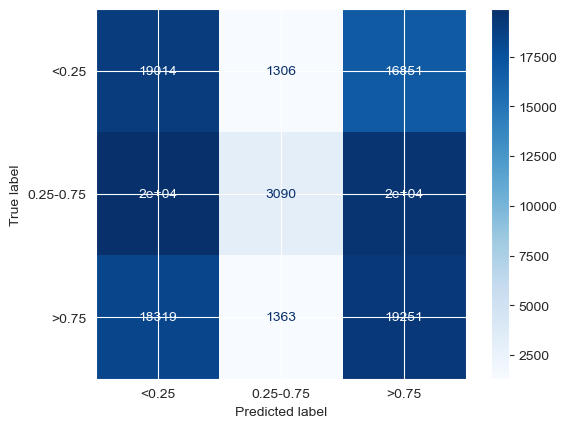

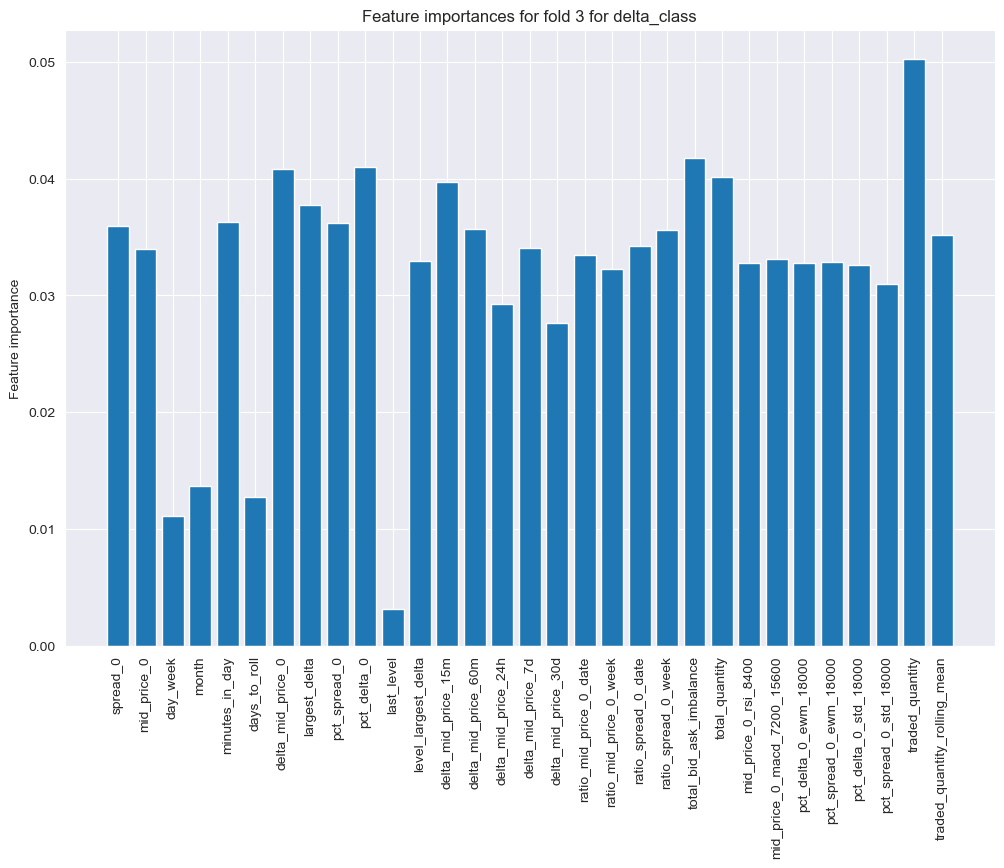

---------------------------------------------------
Accuracy: 0.390

Confusion matrix:
 [[21477  1662 19841]
 [14099  2394 14196]
 [20871  1716 22402]]


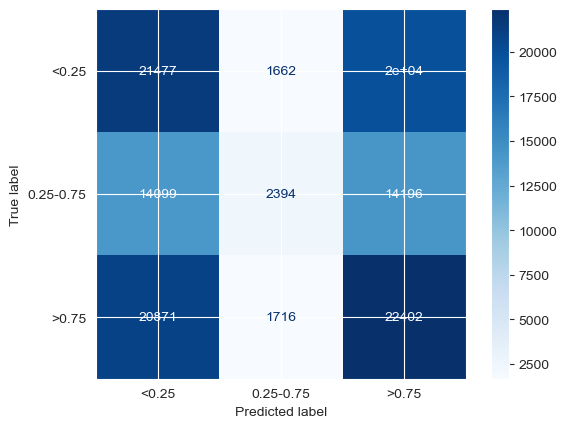

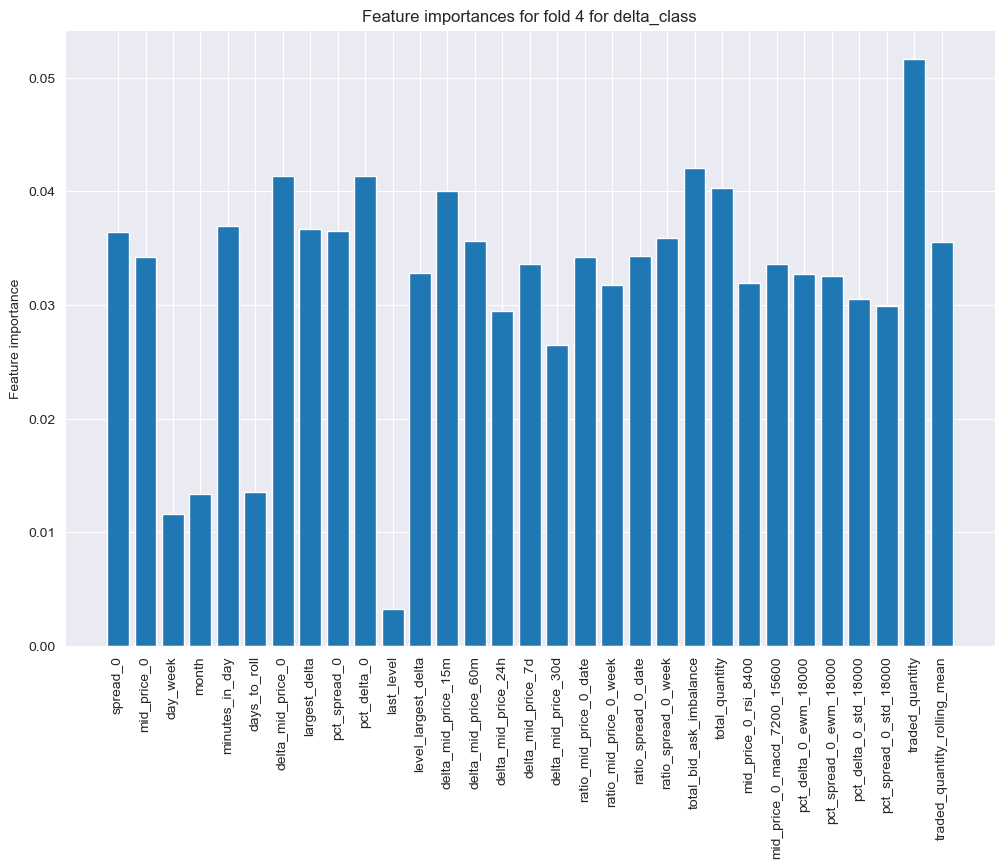

---------------------------------------------------
Accuracy: 0.403

Confusion matrix:
 [[21751  2333 21364]
 [11675  2501 12506]
 [20486  2430 23612]]


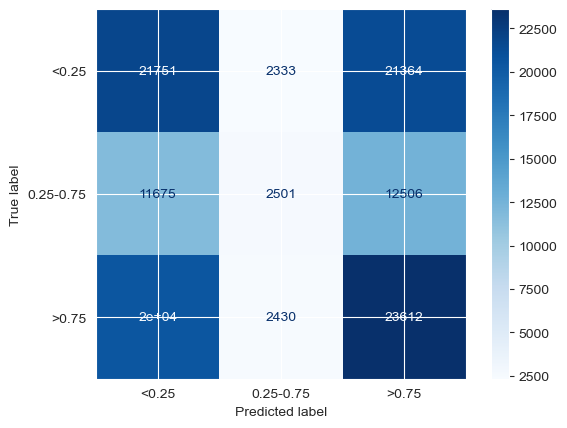

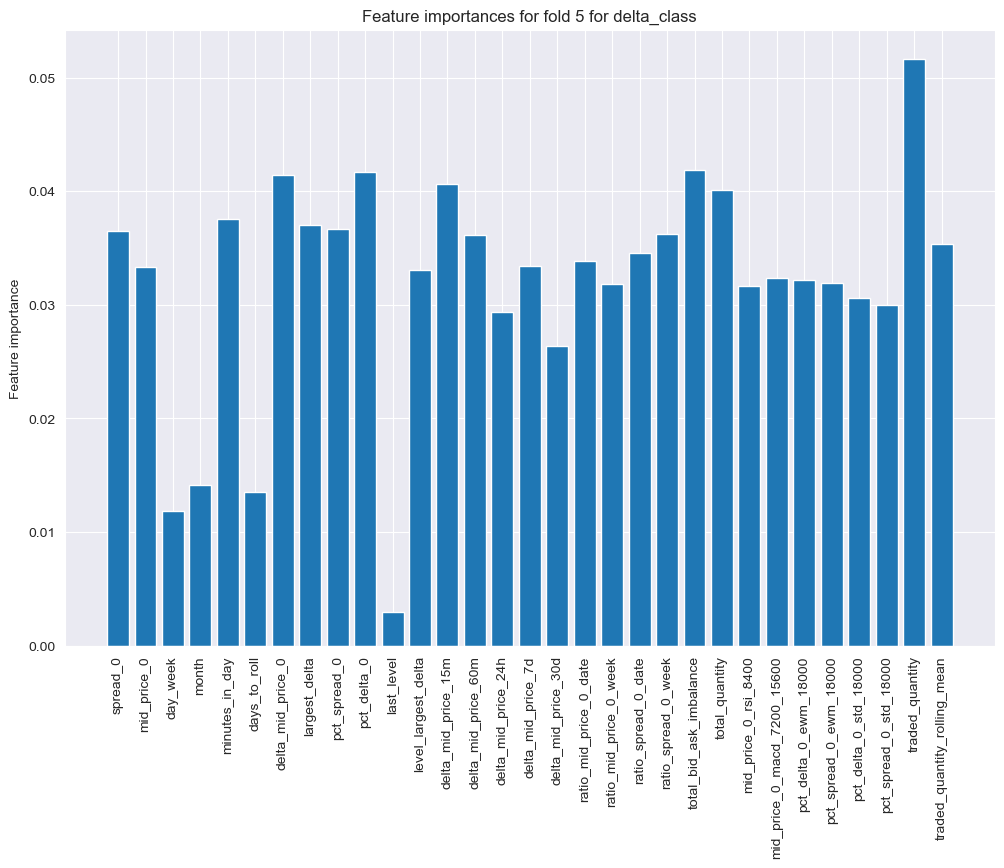

---------------------------------------------------
CV Accuracy delta(mekan ± std over 5 folds): 0.365 ± 0.027


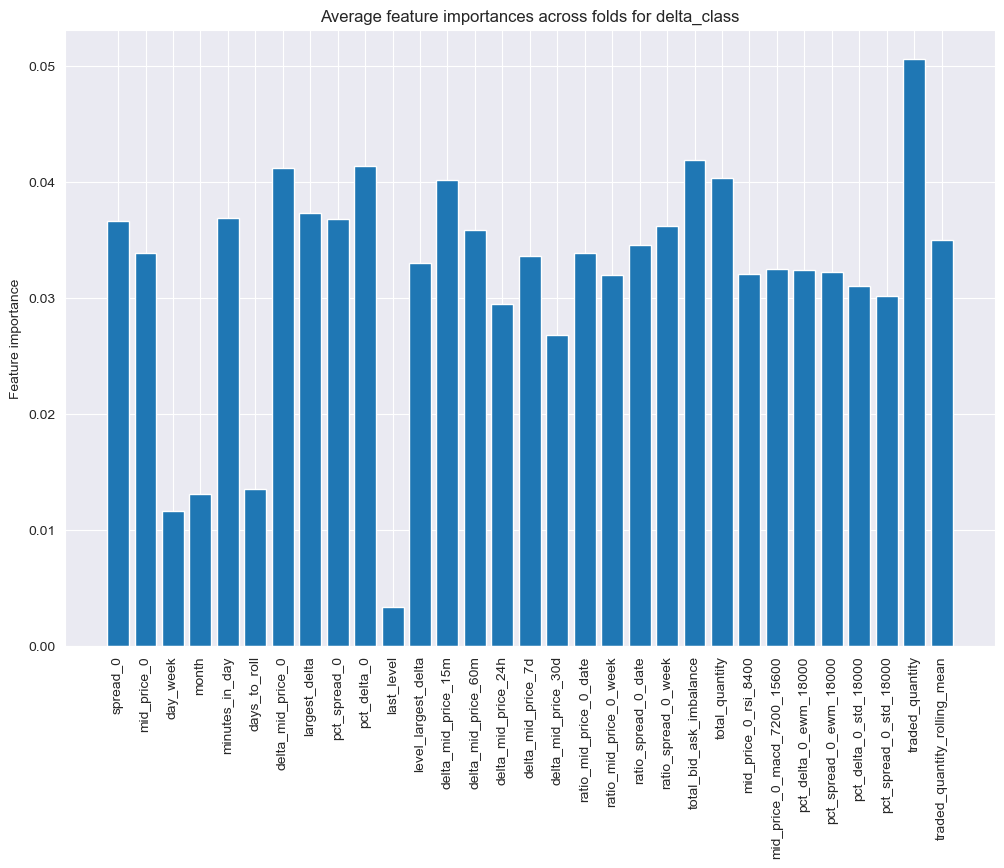

Evaluating spread_class
Accuracy: 0.532

Confusion matrix:
 [[24644 12196 11107]
 [10136 15056 12865]
 [ 4251  4974 23430]]


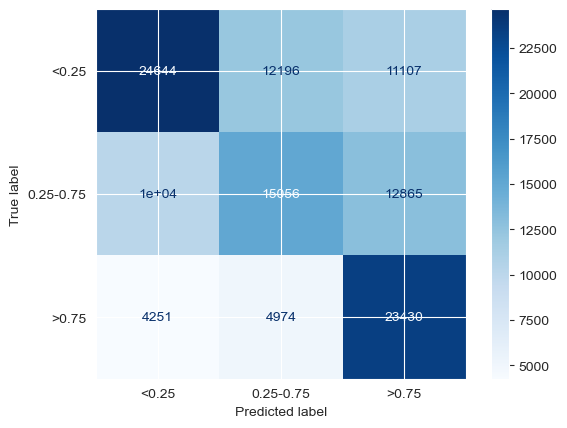

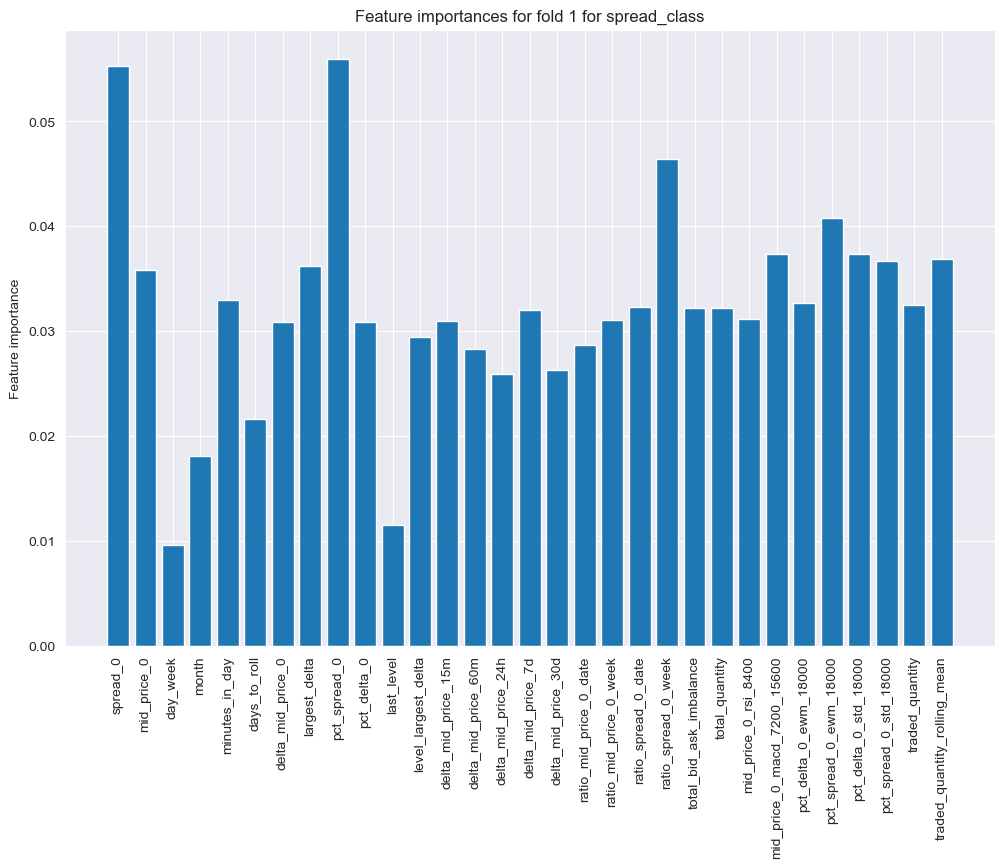

---------------------------------------------------
Accuracy: 0.495

Confusion matrix:
 [[13443 10296  8853]
 [ 8181 15505 12699]
 [ 5781 14152 29748]]


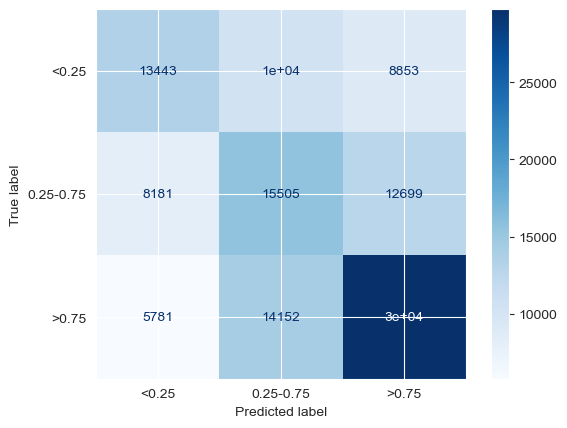

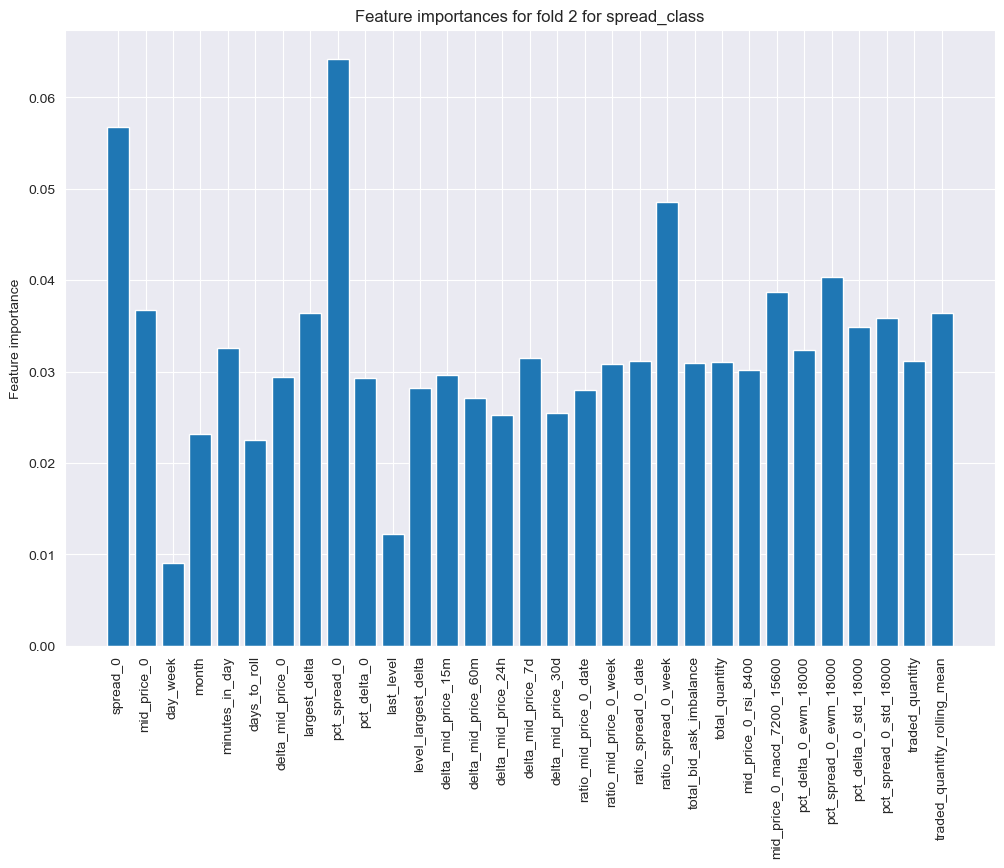

---------------------------------------------------
Accuracy: 0.525

Confusion matrix:
 [[21152  8421  7440]
 [ 9614  9195  8186]
 [ 9326 13362 31962]]


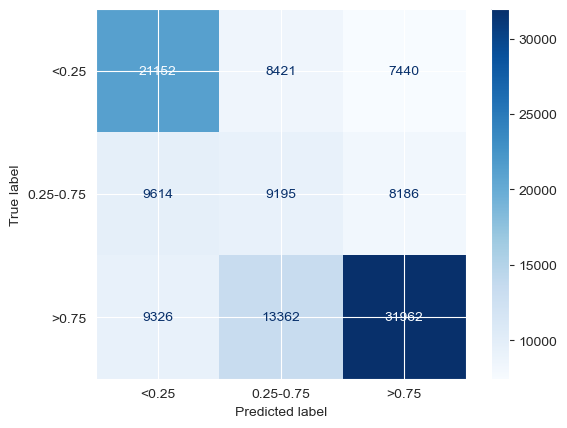

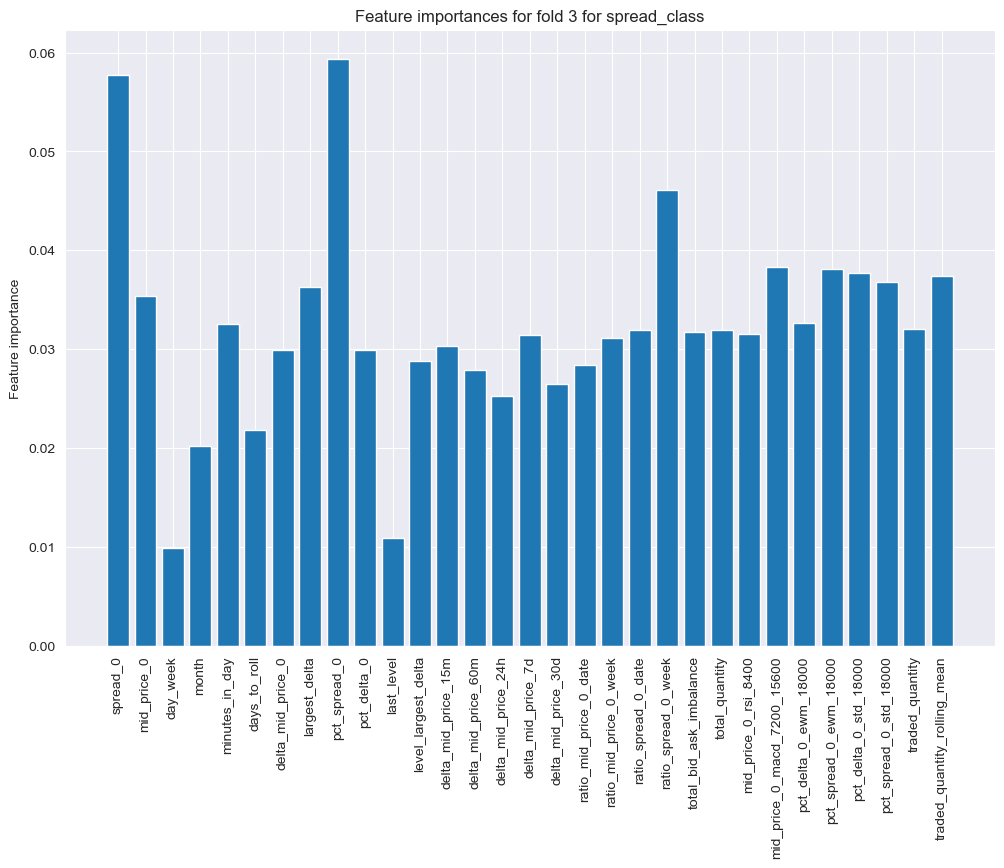

---------------------------------------------------
Accuracy: 0.487

Confusion matrix:
 [[22504 16187  8837]
 [12988 17222 11933]
 [ 5071  5797 18119]]


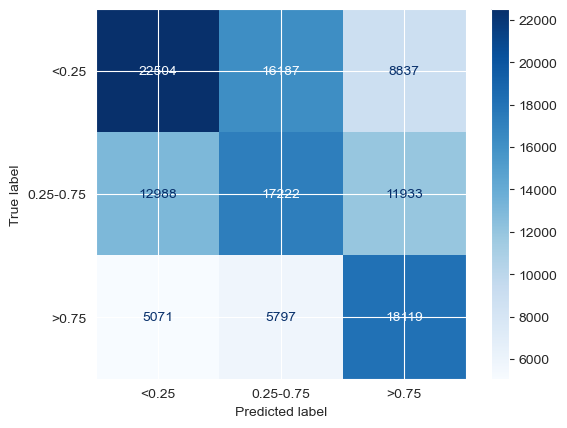

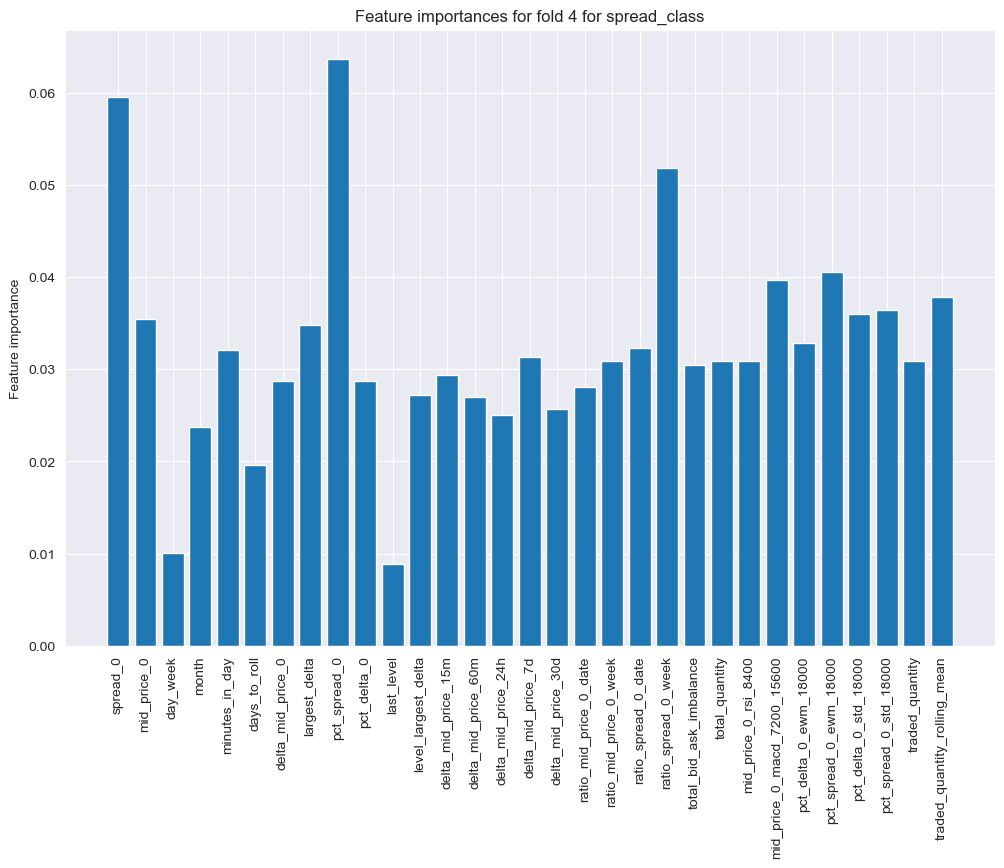

---------------------------------------------------
Accuracy: 0.438

Confusion matrix:
 [[15897  7159  7650]
 [20568 16118 15520]
 [ 8145  7634 19967]]


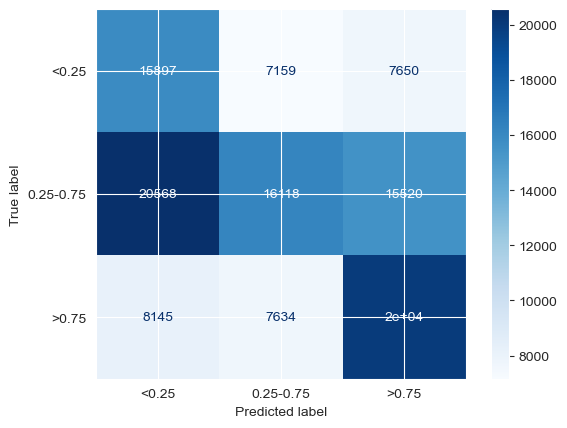

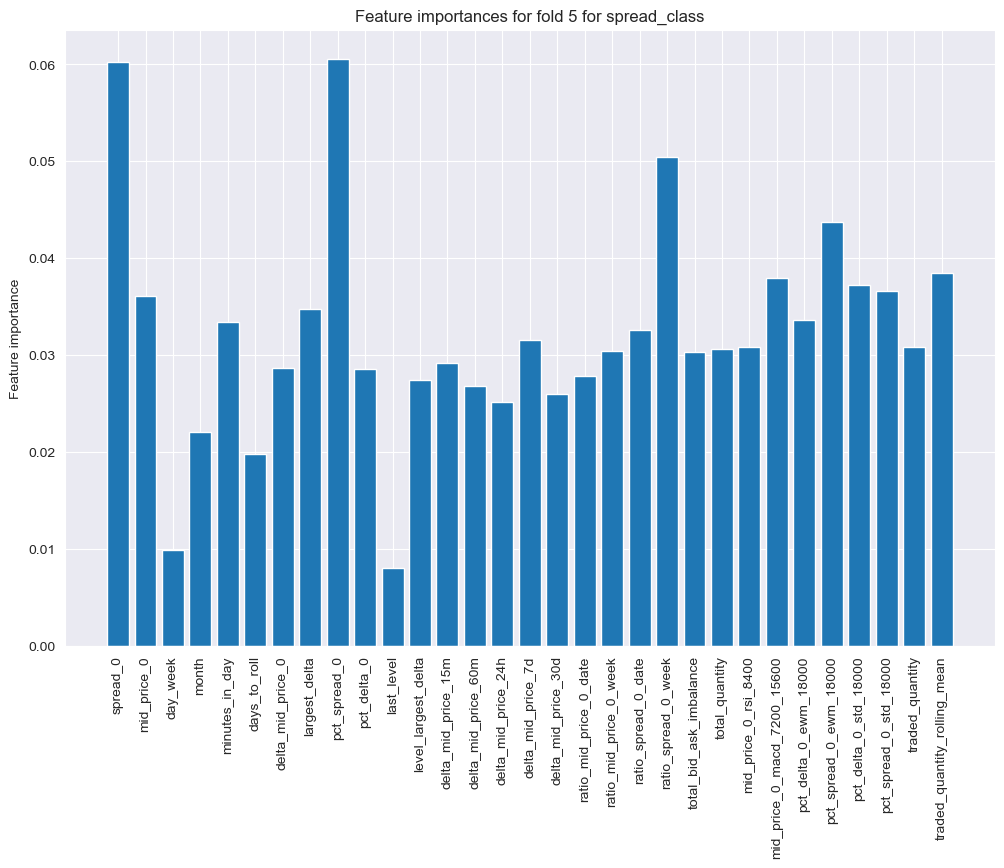

---------------------------------------------------
CV Accuracy delta(mekan ± std over 5 folds): 0.495 ± 0.033


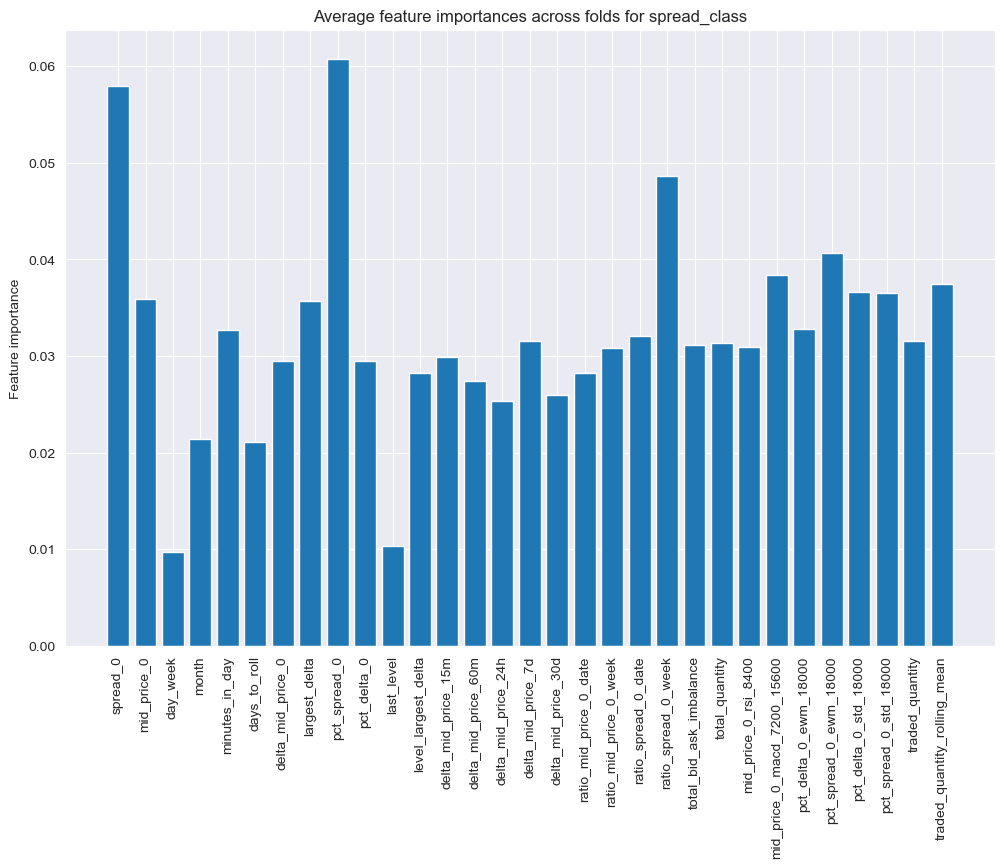

In [19]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

p25_delta, p75_delta, p25_spread, p75_spread = df2.select([
    pl.col("next_pct_delta").quantile(0.33).alias("d25"),
    pl.col("next_pct_delta").quantile(0.66).alias("d75"),
    pl.col("next_pct_spread").quantile(0.33).alias("s25"),
    pl.col("next_pct_spread").quantile(0.66).alias("s75")
]).row(0)

df2 = df2.with_columns([
    pl.when(pl.col("next_pct_delta") < p25_delta).then(0)
      .when(pl.col("next_pct_delta") <= p75_delta).then(1)
      .otherwise(2)
      .alias("delta_class"),

    pl.when(pl.col("next_pct_spread") < p25_spread).then(0)
      .when(pl.col("next_pct_spread") <= p75_spread).then(1)
      .otherwise(2)
      .alias("spread_class")
])

X = df2.select(x_columns).to_numpy()#[::3]

for target in ['delta_class', 'spread_class']:
    print(f'Evaluating {target}')

    y = df2.select(target).to_numpy().flatten()#[::3]

    kf = KFold(n_splits=5, shuffle=False)

    fold_accuracies = []
    fold_importances = []

    fold_idx = 1
    for train_idx, test_idx in kf.split(X):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf2 = ExtraTreesClassifier(n_estimators=100, random_state=42)
        clf2.fit(X_train, y_train)

        y_pred = clf2.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}\n")
        fold_accuracies.append(accuracy)


        cm = confusion_matrix(y_test, y_pred)
        print("Confusion matrix:\n", cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['<0.25', '0.25-0.75', '>0.75'])
        disp.plot(cmap = 'Blues')
        plt.show()
        

        importances = clf2.feature_importances_
        fold_importances.append(importances)

        plt.figure(figsize=(12, 8))
        plt.bar(x_columns, importances)
        plt.xticks(rotation=90)
        plt.ylabel("Feature importance")
        plt.title(f"Feature importances for fold {fold_idx} for {target}")
        plt.show()

        print("---------------------------------------------------")
        fold_idx += 1


    mean_acc = np.mean(fold_accuracies)
    std_acc  = np.std(fold_accuracies)
    print(f"CV Accuracy delta(mekan ± std over {kf.n_splits} folds): {mean_acc:.3f} ± {std_acc:.3f}")

    fold_importances = np.array(fold_importances)
    avg_importances = fold_importances.mean(axis=0)

    plt.figure(figsize=(12, 8))
    plt.bar(x_columns, avg_importances)
    plt.xticks(rotation=90)
    plt.ylabel("Feature importance")
    plt.title(f"Average feature importances across folds for {target}")
    plt.show()
    

In [ ]:
columns = df2.columns


for col in columns:
    plt.figure(figsize=(15,8))
    plt.plot(df['timestamp'], df[col])
    plt.title(col)
    plt.show()

In [ ]:
from datetime import datetime
date = datetime(2020, 1, 16)
df_filtered = df.filter(pl.col('timestamp')<date)
plt.figure(figsize=(15,8))
plt.plot(df_filtered['timestamp'], df_filtered['total_bid_ask_ratio'])
plt.title('total_bid_ask_ratio')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(df_filtered['timestamp'], df_filtered['total_ask_quantity'])
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['mid_price_0_macd_7200_15600'], label='macd', color='blue')
plt.plot(df['timestamp'], df['mid_price_0_macd_signal_7200_15600'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['mid_price_0'])
plt.show()

date = datetime(2020, 1, 22)
plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_60_180'], label='macd', color='blue')
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_signal_60_180'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0_macd_60_180'] - df.filter(pl.col('timestamp')<date)['mid_price_0_macd_signal_60_180'], label='signal', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df.filter(pl.col('timestamp')<date)['timestamp'], df.filter(pl.col('timestamp')<date)['mid_price_0'])
plt.show()



In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_1800'])
plt.show()
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_4200'])
plt.show()
plt.figure(figsize=(15,8))
plt.plot(df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['timestamp'], df.filter(pl.col('mid_price_0_rsi_1800').sub(0.5).abs() < 0.2)['mid_price_0_rsi_8400'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(df['timestamp'], df['mid_price_0'])
plt.show()